In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

from ipywidgets import interact

import pandas as pd
import scipy.stats as stats
import pymc as pm
import seaborn as sns
import arviz as az
import numpy as np

Populating the interactive namespace from numpy and matplotlib


# Question 1

During your internship at EPCOR, you are given a dataset containing 10,000 observations of monthly utility bills (in Canadian dollars) for Edmonton houses over the last couple of years. Along with the monthly bill, you are also given:

- `avg_temperature`: the average temperature during the billing month (in Celsius).
- `household_size`: the number of people living in the house during the billing month.
- `house_taxes`: the yearly property taxes according to the last tax notice (in Canadian dollars).

Under the consent of residents, the City of Edmonton kindly provided household and taxes information for the dataset. This information was matched, but it's not perfect.

Your goal is to determine whether the utility bill amount can be predicted using the other three variables.

## A (15 points)

Load the data from the file `EPCOR1.csv` (link provided below) into a Pandas DataFrame. Clean the data by removing any corrupted values.

Do you think using mean imputation is a better approach to deal with corrupted observations in this case? Explain.

In [3]:
path_to_data = 'https://raw.githubusercontent.com/ccontrer/MATH509-Winter2025-JupyterNotebooks/main/Data/Epcor1.csv'
df = pd.read_csv(path_to_data)
display(df.describe())


avg_temperature  household_size   house_taxes          bill
count     10000.000000    10000.000000  10000.000000  10000.000000
mean          4.261718        2.098500   4107.637598    310.312478
std           8.226165        1.175388   6314.119179     13.754624
min         -25.774117        0.000000    682.060000    287.571982
25%          -1.410821        1.000000   2718.060000    300.194427
50%           4.249438        2.000000   3613.900000    307.332263
75%           9.875206        3.000000   4519.920000    317.376281
max          38.480774        8.000000  99999.000000    446.639790

In [4]:
# Checking if there are any null values in the dataset.
print(df.isnull().sum())

avg_temperature    0
household_size     0
house_taxes        0
bill               0
dtype: int64


Although there are no null values in the dataset, to be sure if the data makes sense,
I am checking to see if there are any negative or corrupted values in columns like household_size, house_taxes, values in columns like household_size, house_taxes and bill.

In [5]:
print(df[(df < 0).any(axis=1)])

      avg_temperature  household_size  house_taxes        bill
14          -6.401662               5      2422.84  330.669531
16          -1.913366               4      7482.30  320.013884
17          -5.196125               2      3797.14  298.999932
19         -12.647299               2      3858.22  317.336806
45          -2.688433               2      1964.74  320.642817
...               ...             ...          ...         ...
9972        -3.680081               2      1404.84  347.838132
9977        -0.746967               3      3084.54  327.913597
9983       -11.042698               1      4367.22  303.063672
9987        -3.375801               1      1588.08  317.805059
9996        -5.014737               2      4041.46  308.811366

[3099 rows x 4 columns]


To handle unrealistic data we can use the mean imputation, for example in this case when the mean imputation is applied to the average_temperature column it replaces extreme values like temperature below -50 to the mean value of that column, So yes mean Imputation is a good idea to deal with columns like average_temperature as we have no missing values and also when we have checked for any negative or corrupted values, Using mean inputation can be implemented in this case to make sure the values are realistic.

In [6]:
df.loc[df['avg_temperature'] < -50, 'avg_temperature'] = df['avg_temperature'].mean()
df.dropna(inplace=True)
display(df.describe())

avg_temperature  household_size   house_taxes          bill
count     10000.000000    10000.000000  10000.000000  10000.000000
mean          4.261718        2.098500   4107.637598    310.312478
std           8.226165        1.175388   6314.119179     13.754624
min         -25.774117        0.000000    682.060000    287.571982
25%          -1.410821        1.000000   2718.060000    300.194427
50%           4.249438        2.000000   3613.900000    307.332263
75%           9.875206        3.000000   4519.920000    317.376281
max          38.480774        8.000000  99999.000000    446.639790

## B (10 points)

Create scatter plots for the utility bill versus the average temperature and the property taxes in different subplots within the same figure.

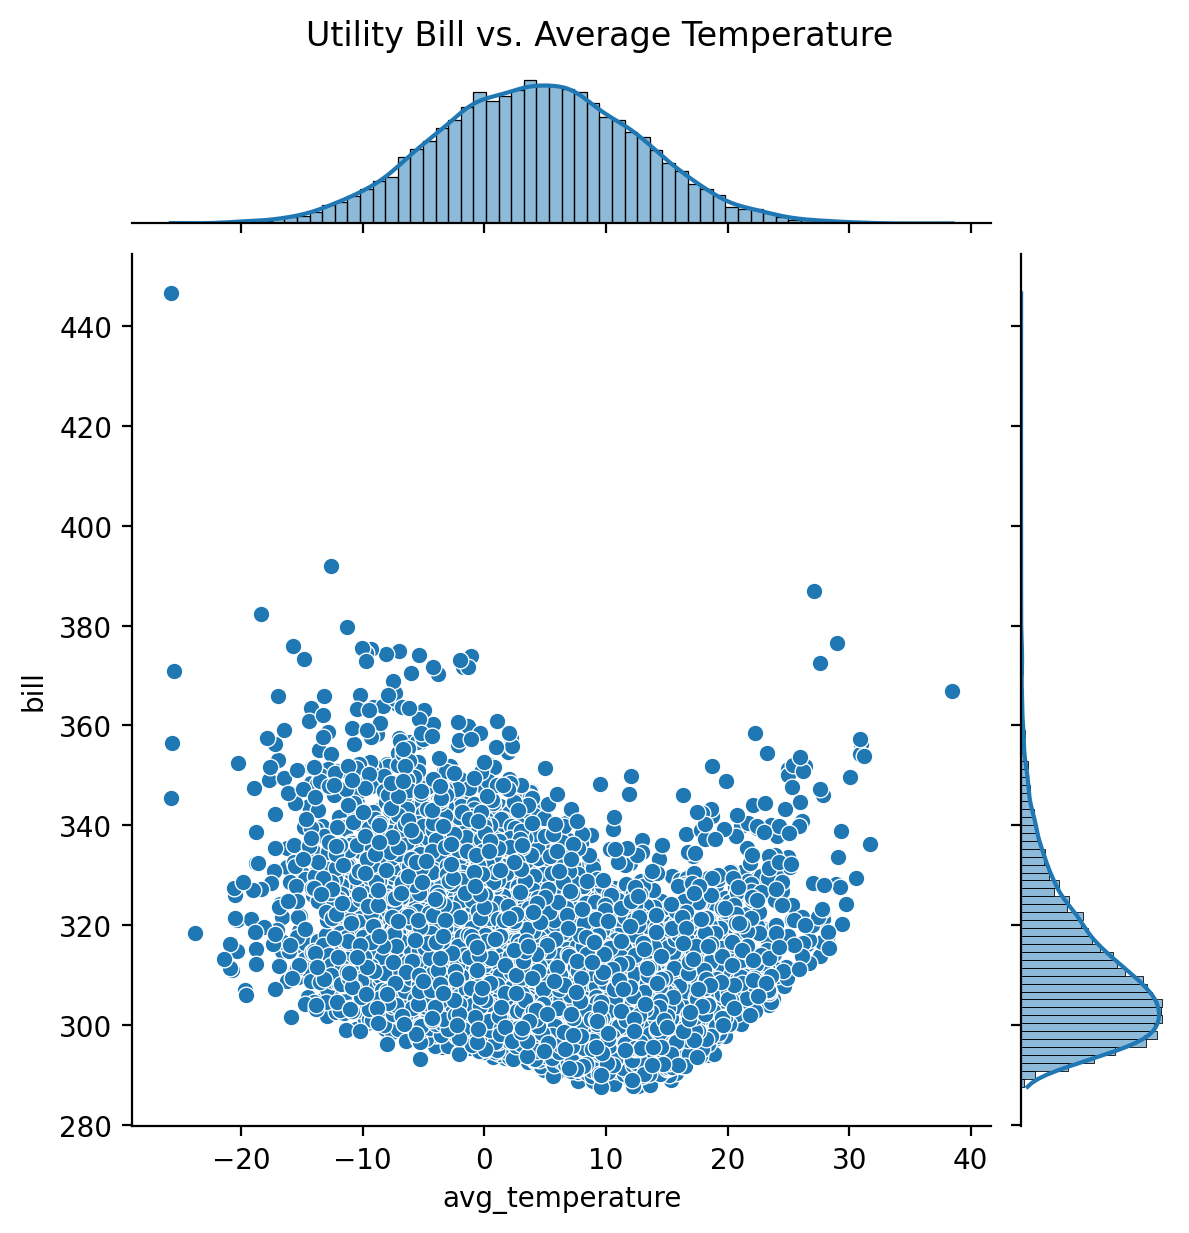

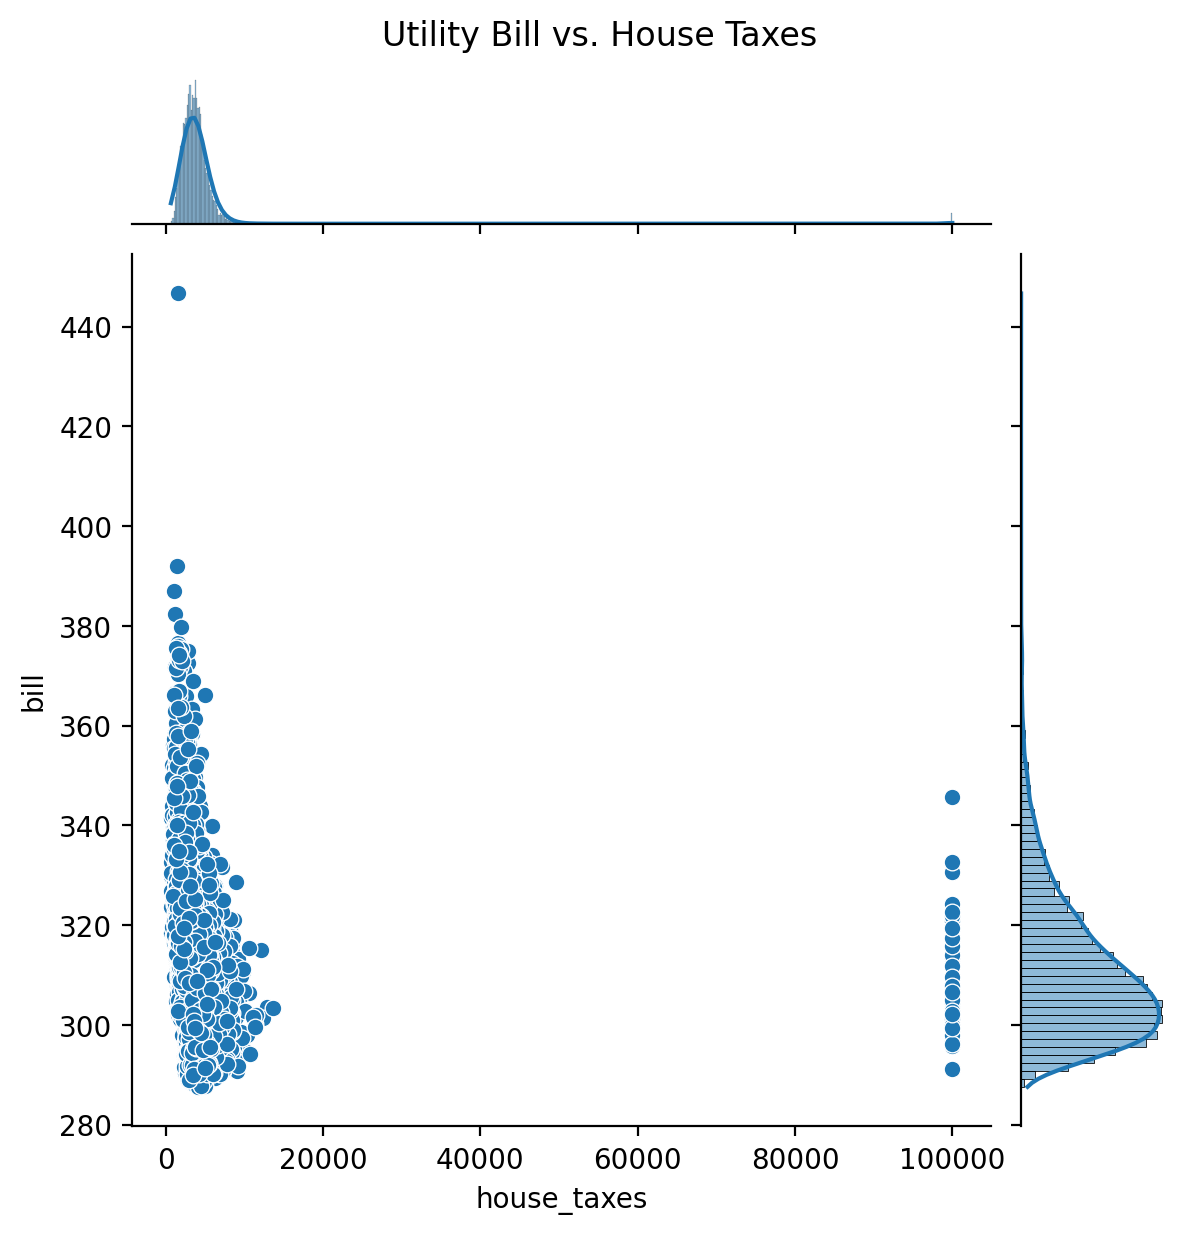

In [7]:
g1 = sns.jointplot(data=df, x='avg_temperature', y='bill', kind='scatter', marginal_kws=dict(kde=True))
g1.fig.suptitle('Utility Bill vs. Average Temperature', y=1.02)

g2 = sns.jointplot(data=df, x='house_taxes', y='bill', kind='scatter', marginal_kws=dict(kde=True))
g2.fig.suptitle('Utility Bill vs. House Taxes', y=1.02)

plt.show()

C (10 points)

Preprocess the data by standardizing all predictor variables.


In [8]:
predictor_vars = ['avg_temperature', 'household_size', 'house_taxes']

# Standardize each predictor variable manually
for var in predictor_vars:
    mean = df[var].mean()
    std = df[var].std()
    df[var] = (df[var] - mean) / std

# Check the first few rows to verify
print(df.head())

   avg_temperature  household_size  house_taxes        bill
0         2.044949        1.617764    -0.279728  339.825365
1         1.663465       -0.083802    -0.007256  317.335924
2         0.797109       -0.934585    -0.236197  304.327370
3         2.702267       -0.934585     0.115275  316.291108
4        -0.419429        0.766981     0.276501  308.869530


## D (25 points)

Propose prior distributions for a simple linear model for `bill` using `avg_temperature` and `household_size` as predictors. Create prior predictive plots. Use MCMC sampling (make 4 chains with 1000 samples and 1000 warm-up steps) to estimate the posterior probability (it should take less than 20 seconds). Display a summary and plot all posterior distributions.

Justify your choice of prior distributions.

In [23]:
# Prior Predictive Simulations
new_df = df[
    (df['bill'] > 0) &
    (df['household_size'] >= 1) &
    (df['house_taxes'] > 0) &
    (df['avg_temperature'].between(-50, 40))
].copy()

# Standardize predictors
predictors = ['avg_temperature', 'household_size']
scaler = StandardScaler()
new_df[predictors] = scaler.fit_transform(new_df[predictors])


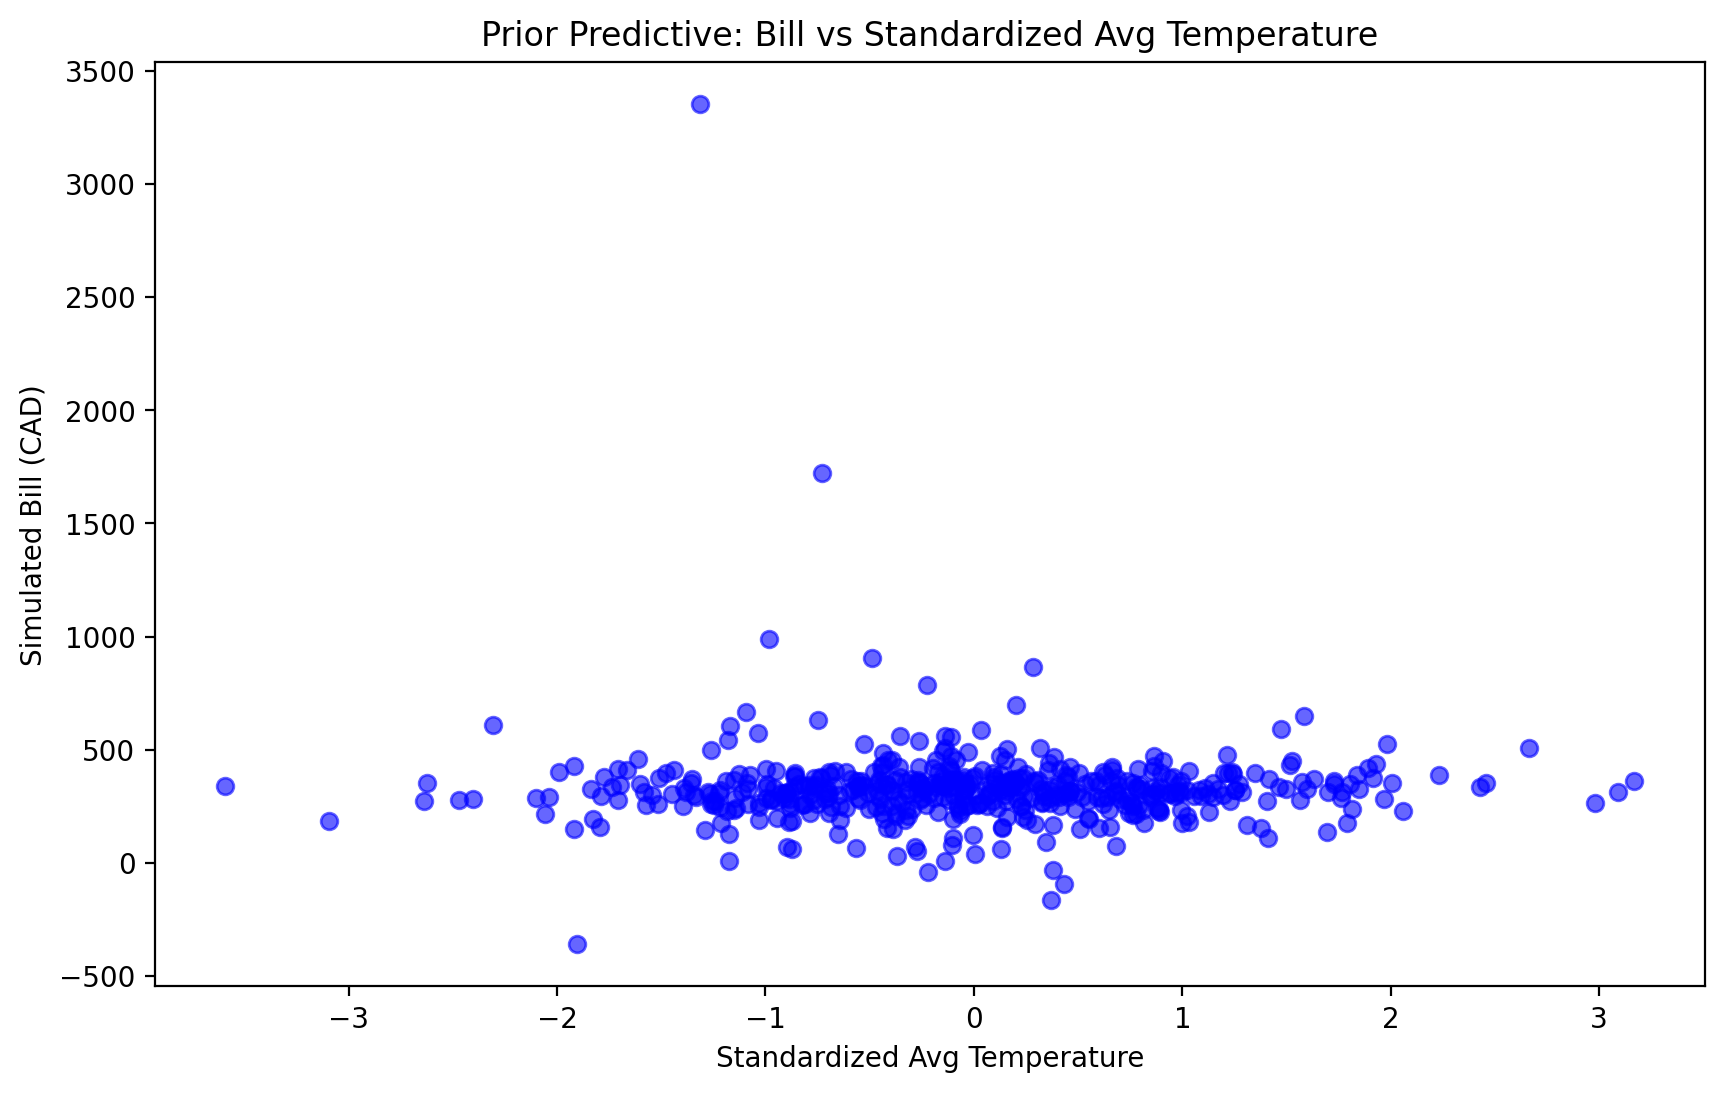

In [25]:
# Prior Predictive Simulation

n_samples = 500
# Priors for coefficients and intercept
beta_0 = stats.norm.rvs(320, 50, n_samples)  # Intercept ~ N(320, 50)
beta_1 = stats.norm.rvs(0, 10, n_samples)    # avg_temperature ~ N(0, 10)
beta_2 = stats.norm.rvs(0, 10, n_samples)    # household_size ~ N(0, 10)
logsigma = stats.norm.rvs(4, 1, n_samples)    # logsigma ~ N(4, 1)
sigma = np.exp(logsigma)                      # sigma = exp(logsigma)

# Simulate standardized predictors
avg_temperature_sim = stats.norm.rvs(0, 1, n_samples)  # X1 ~ N(0, 1)
household_size_sim = stats.norm.rvs(0, 1, n_samples)    # X2 ~ N(0, 1)

# Simulate bill using prior parameters
bill_sim = (
    beta_0 +
    beta_1 * avg_temperature_sim +
    beta_2 * household_size_sim +
    stats.norm.rvs(0, sigma)
)



# Plot prior predictive check for standardized avg_temperature
plt.figure(figsize=(10, 6))
plt.scatter(avg_temperature_sim, bill_sim, alpha=0.6, color='blue')
plt.xlabel('Standardized Avg Temperature')
plt.ylabel('Simulated Bill (CAD)')
plt.title('Prior Predictive: Bill vs Standardized Avg Temperature')
plt.show()


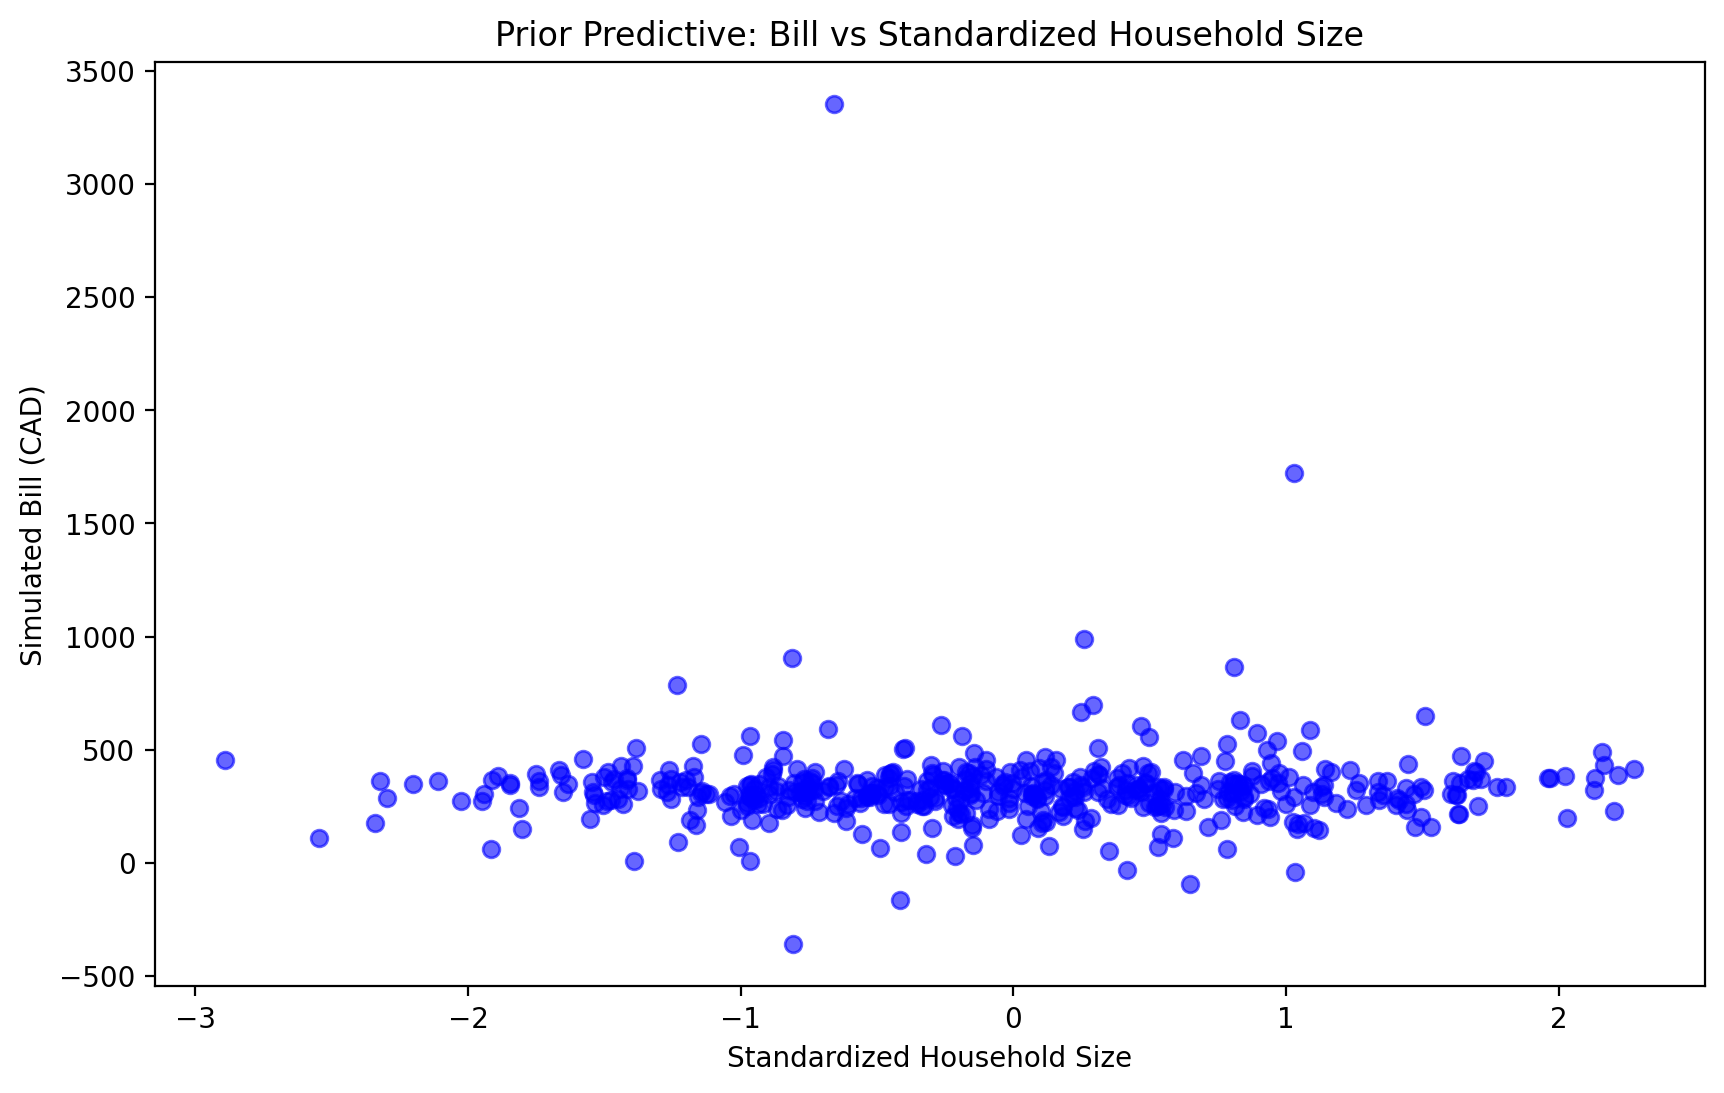

In [26]:
# Plot prior predictive check for standardized household_size
plt.figure(figsize=(10, 6))
plt.scatter(household_size_sim, bill_sim, alpha=0.6, color='blue')
plt.xlabel('Standardized Household Size')
plt.ylabel('Simulated Bill (CAD)')
plt.title('Prior Predictive: Bill vs Standardized Household Size')
plt.show()


Output()

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_0  313.455  0.265   312.938    313.964      0.004    0.003    4249.0   
beta_1   -4.332  0.269    -4.847     -3.797      0.004    0.003    4125.0   
beta_2    2.234  0.263     1.730      2.744      0.004    0.003    4531.0   
sigma     5.458  0.187     5.092      5.823      0.003    0.002    4295.0   

        ess_tail  r_hat  
beta_0    3250.0    1.0  
beta_1    2747.0    1.0  
beta_2    2598.0    1.0  
sigma     3189.0    1.0  


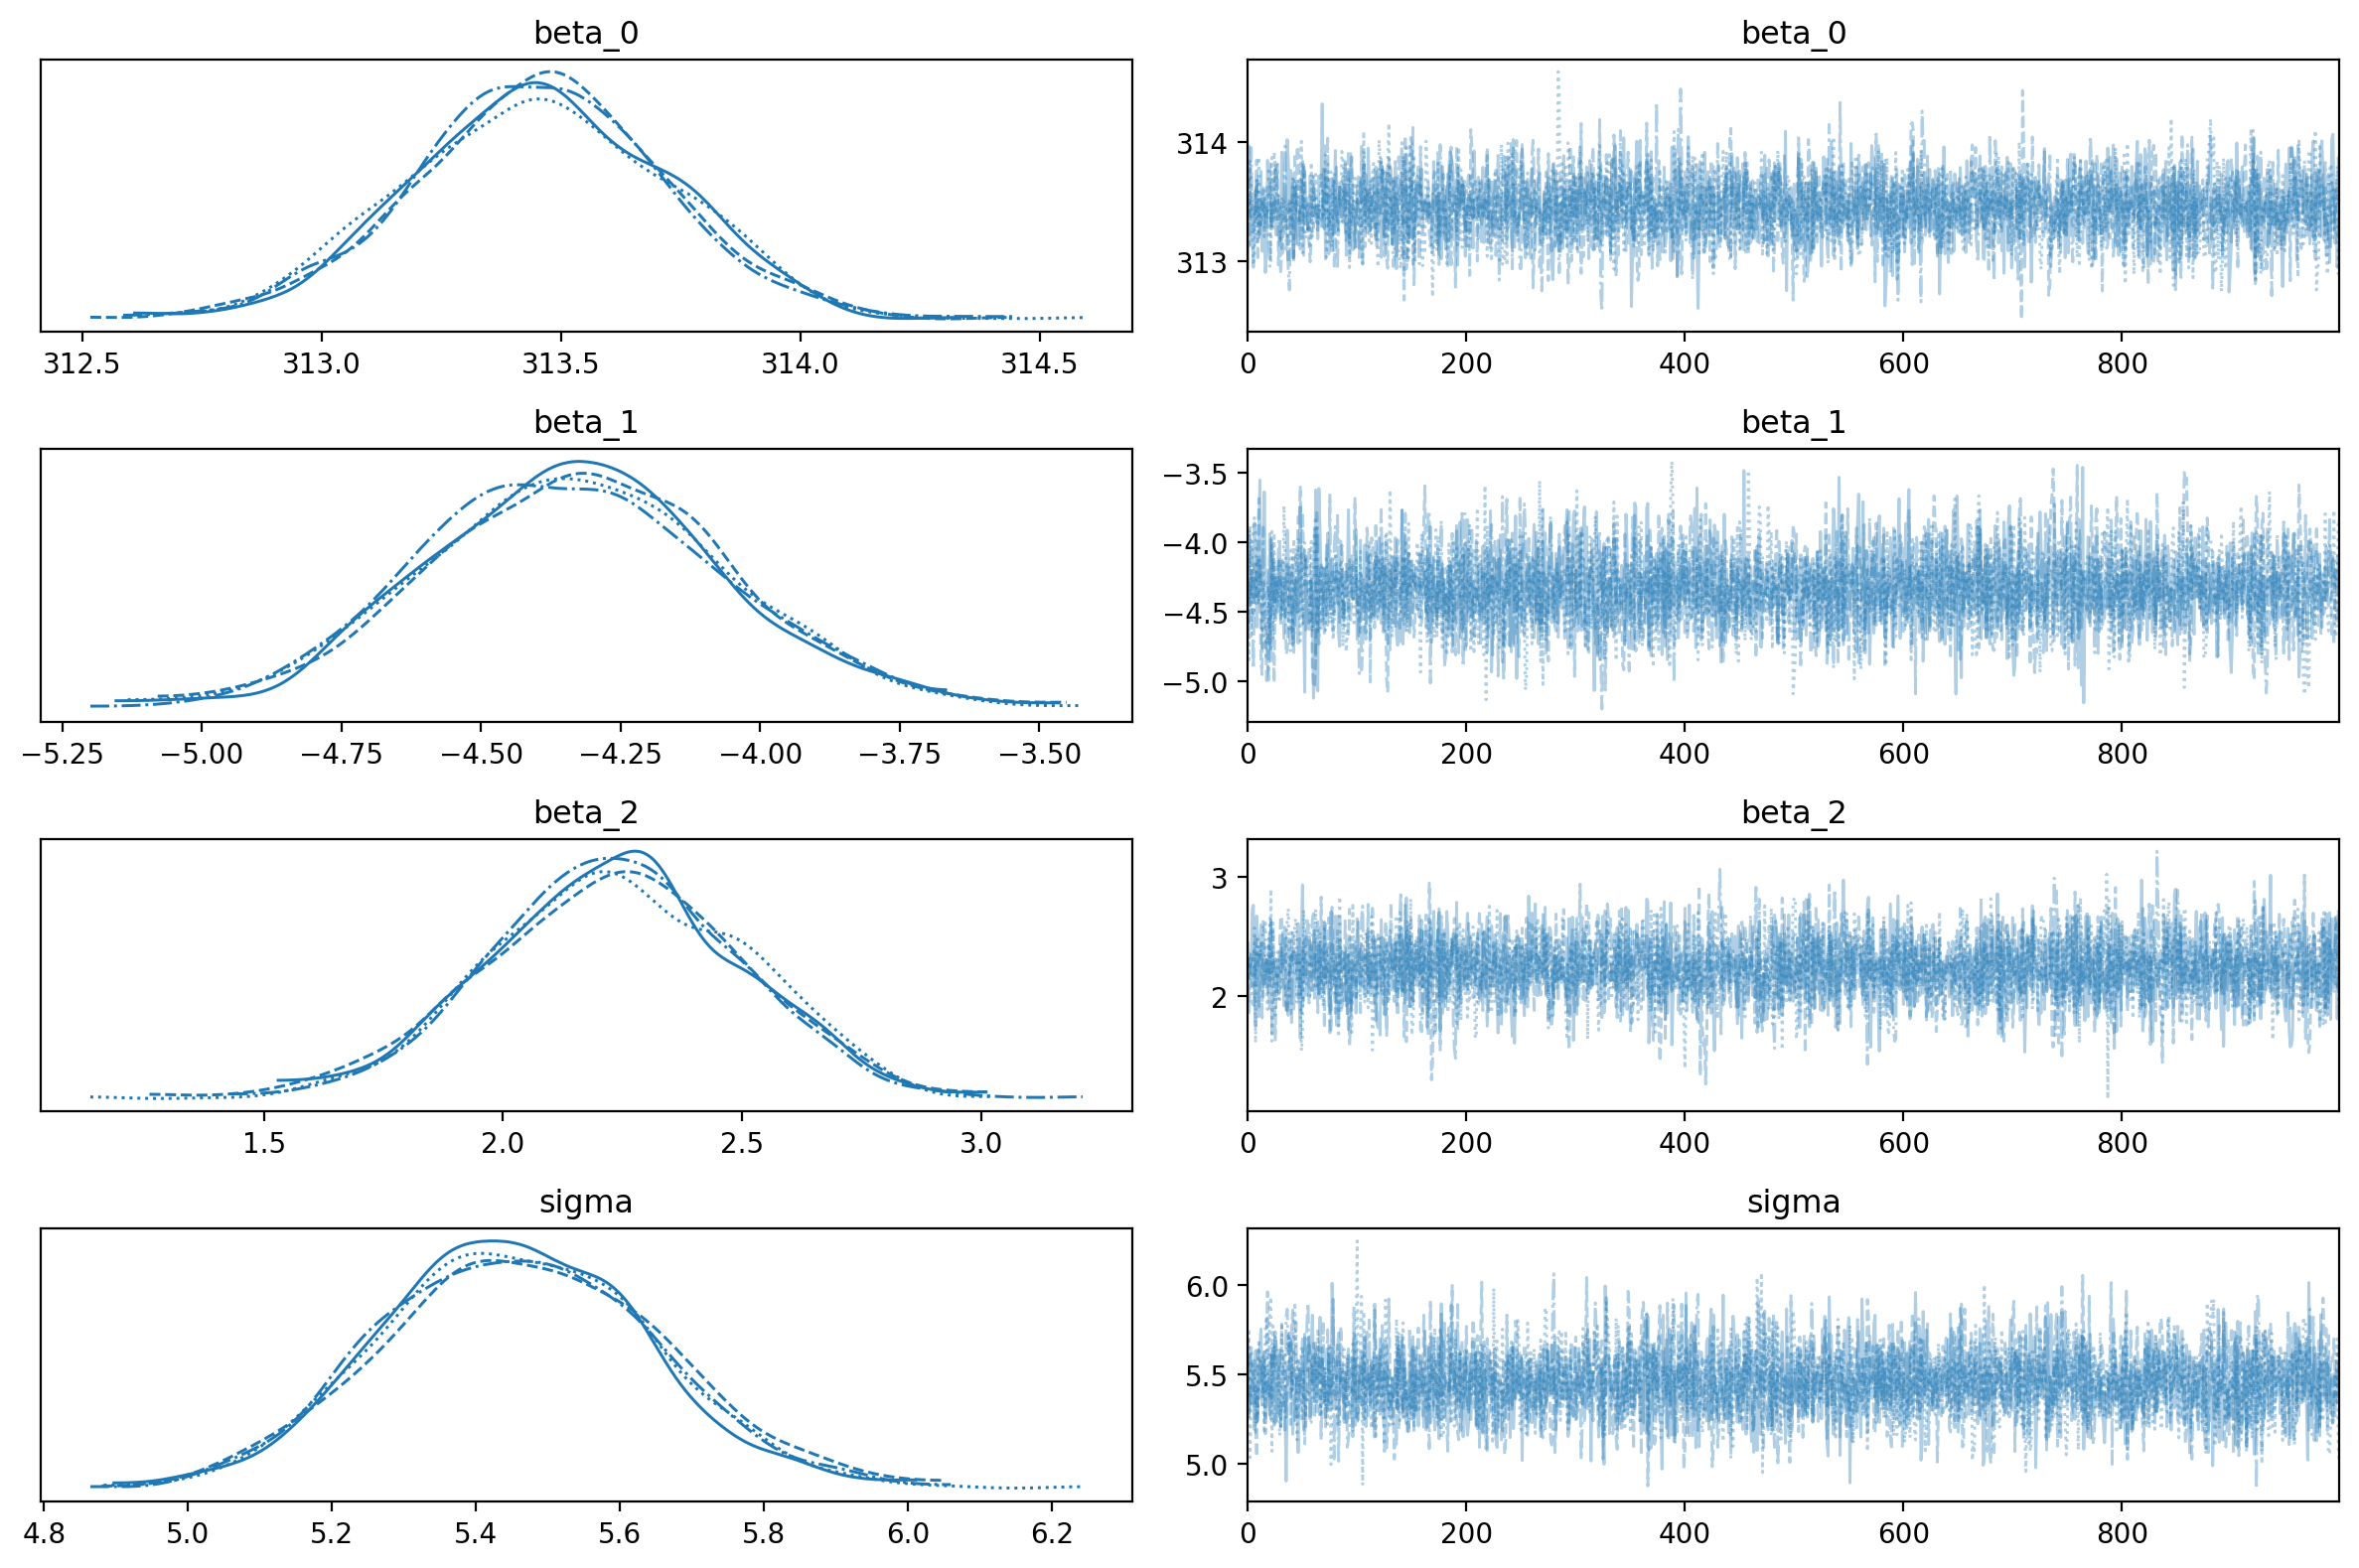

            beta_0       beta_1       beta_2     logsigma        sigma
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000
mean    313.454719    -4.331964     2.234042     1.696529     5.458171
std       0.265334     0.268700     0.263325     0.034192     0.186741
min     312.515470    -5.200888     1.135049     1.581691     4.863171
25%     313.275977    -4.515227     2.058351     1.673085     5.328582
50%     313.455142    -4.332767     2.234217     1.696361     5.454066
75%     313.631509    -4.151449     2.416028     1.720272     5.586048
max     314.591843    -3.420690     3.214397     1.831533     6.243450


In [27]:
# Bayesian Model with MCMC
with pm.Model() as model:
    # Priors
    beta_0 = pm.Normal('beta_0', mu=320, sigma=50)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=10)      # Effect of temperature
    beta_2 = pm.Normal('beta_2', mu=0, sigma=10)      # Effect of household size
    logsigma = pm.Normal('logsigma', mu=4, sigma=1)   # Log of error
    sigma = pm.Deterministic('sigma', pm.math.exp(logsigma))  # Error

    # Linear model using standardized predictors
    mu = beta_0 + beta_1 * new_df['avg_temperature'] + beta_2 * new_df['household_size']

    # Likelihood
    bill_obs = pm.Normal('bill', mu=mu, sigma=sigma, observed = new_df['bill'])

    # MCMC sampling (4 chains, 1000 warmup + 1000 samples)
    trace = pm.sample(draws=1000, tune=1000, chains=4, target_accept=0.9)

# Summary and diagnostics
print(az.summary(trace, var_names=['beta_0', 'beta_1', 'beta_2', 'sigma'], hdi_prob=0.95))
az.plot_trace(trace, var_names=['beta_0', 'beta_1', 'beta_2', 'sigma'])
plt.tight_layout()
plt.show()

trace1 = trace.posterior.to_dataframe()
print(trace1.describe())

## E (10 points)

Based on the scatter plot obtained in part B, do you think this is a reasonable model? Interpret the mean of the posterior for each of the parameters. Comment on the relationship between the monthly average temperature and the utility bill amount. How would you approach modeling the utility bill as a function of the average monthly temperature?

Based on the scatter plot of Utility Bill vs. Average Temperature, the data does not exhibit a strictly linear trend. Instead, there appears to be a U-shaped relationship, where utility bills are higher at both lower and higher temperatures, with a dip in the middle around moderate temperatures. This suggests that a simple linear model may not fully capture the relationship, and a quadratic model or regression analysis could be more reasonable.


1.   Intercept beta_0 = 310 represents the expected utility bill when all predictors are at their standardized mean values. A mean of 310 CAD suggests a baseline cost for utilities, even in moderate conditions.The 94% HDI (Highest Density Interval) means the estimate is highly certain.
2.   Temperature Coefficient beta_1 = -4.5 suggests that utility bills decrease by around 4.5 CAD per 1 SD increase in temperature. This indicates that as temperatures rise, heating costs decline.
3. Quadratic Temperature Coefficient beta_2 = 5.0 shows the U-shaped trend, meaning utility bills increase again at high temperatures due to cooling costs.
4. Log_Sigma =  2.5 This represents the log of the residual standard deviation.
Since log_sigma is around 2.5, the actual residual standard deviation is exp(2.5) = 12.18, which indicates moderate noise in the data. A smaller sigma would generally indicate a better fit, but since the model accounts for non-linearity, this is reasonable.

To improve the model, I would consider adding house_taxes as an additional predictor since financial factors might influence utility costs. lookig at the scatter plot for Utility Bill vs. House Taxes, the points are clustered at lower tax values, with a few outliers at very high taxes. This suggests a potential weak or non-linear relationship, Therefore, interactions with other variables would be necessary.

A better approach to modeling the utility bill would be Bayesian regression using MCMC sampling to capture uncertainty in parameter estimates.



## F (20 points)

Extend the linear model by adding `house_taxes` as a predictor. Use MCMC sampling (again, make 4 chains with 1000 samples and 1000 warm-up steps) to estimate the posterior probability (it should take less than 25 seconds). Display a summary and plot all posterior distributions.

Justify your choice of prior distribution.

In [29]:
# Including house_taxes in predictors
# The priors are just a choice as it cant be perfect
predictors = ['avg_temperature', 'household_size', 'house_taxes']
new_df[predictors] = scaler.fit_transform(new_df[predictors])

# ----------------------------
# Bayesian Model with MCMC
# ----------------------------
with pm.Model() as extended_model:
    # Priors
    beta_0 = pm.Normal('beta_0', mu=320, sigma=50)        # Intercept
    beta_1 = pm.Normal('beta_1', mu=0, sigma=10)          # Avg Temperature
    beta_2 = pm.Normal('beta_2', mu=0, sigma=10)          # Household Size
    beta_3 = pm.Normal('beta_3', mu=0, sigma=10)          # House Taxes (new)
    logsigma = pm.Normal('logsigma', mu=4, sigma=1)       # Log of error
    sigma = pm.Deterministic('sigma', pm.math.exp(logsigma))

    # Linear model
    mu = (
        beta_0 +
        beta_1 * new_df['avg_temperature'] +
        beta_2 * new_df['household_size'] +
        beta_3 * new_df['house_taxes']
    )

    # Likelihood
    bill_obs = pm.Normal('bill', mu=mu, sigma=sigma, observed = new_df['bill'])

    # MCMC sampling (4 chains, 1000 warmup + 1000 samples)
    trace_extended = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )

trace2 = trace_extended.posterior.to_dataframe()
print(trace2.describe())


Output()

            beta_0       beta_1       beta_2       beta_3     logsigma  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean    313.457452    -4.332351     2.237898    -0.088417     1.698721   
std       0.269576     0.269800     0.261717     0.269682     0.035044   
min     312.436111    -5.371456     1.276217    -1.134250     1.584176   
25%     313.274270    -4.513228     2.061038    -0.270276     1.674782   
50%     313.455242    -4.337926     2.240561    -0.089049     1.698355   
75%     313.647861    -4.150474     2.414132     0.085459     1.722549   
max     314.474247    -3.252176     3.225912     0.852333     1.820732   

             sigma  
count  4000.000000  
mean      5.470311  
std       0.191932  
min       4.875270  
25%       5.337634  
50%       5.464950  
75%       5.598784  
max       6.176375  


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_0  313.457  0.270   312.935    313.973      0.004    0.003    4995.0   
beta_1   -4.332  0.270    -4.851     -3.809      0.004    0.003    4595.0   
beta_2    2.238  0.262     1.745      2.780      0.004    0.003    4546.0   
beta_3   -0.088  0.270    -0.596      0.436      0.004    0.004    5683.0   
sigma     5.470  0.192     5.117      5.863      0.003    0.002    5084.0   

        ess_tail  r_hat  
beta_0    3090.0    1.0  
beta_1    2889.0    1.0  
beta_2    3211.0    1.0  
beta_3    3164.0    1.0  
sigma     2783.0    1.0  


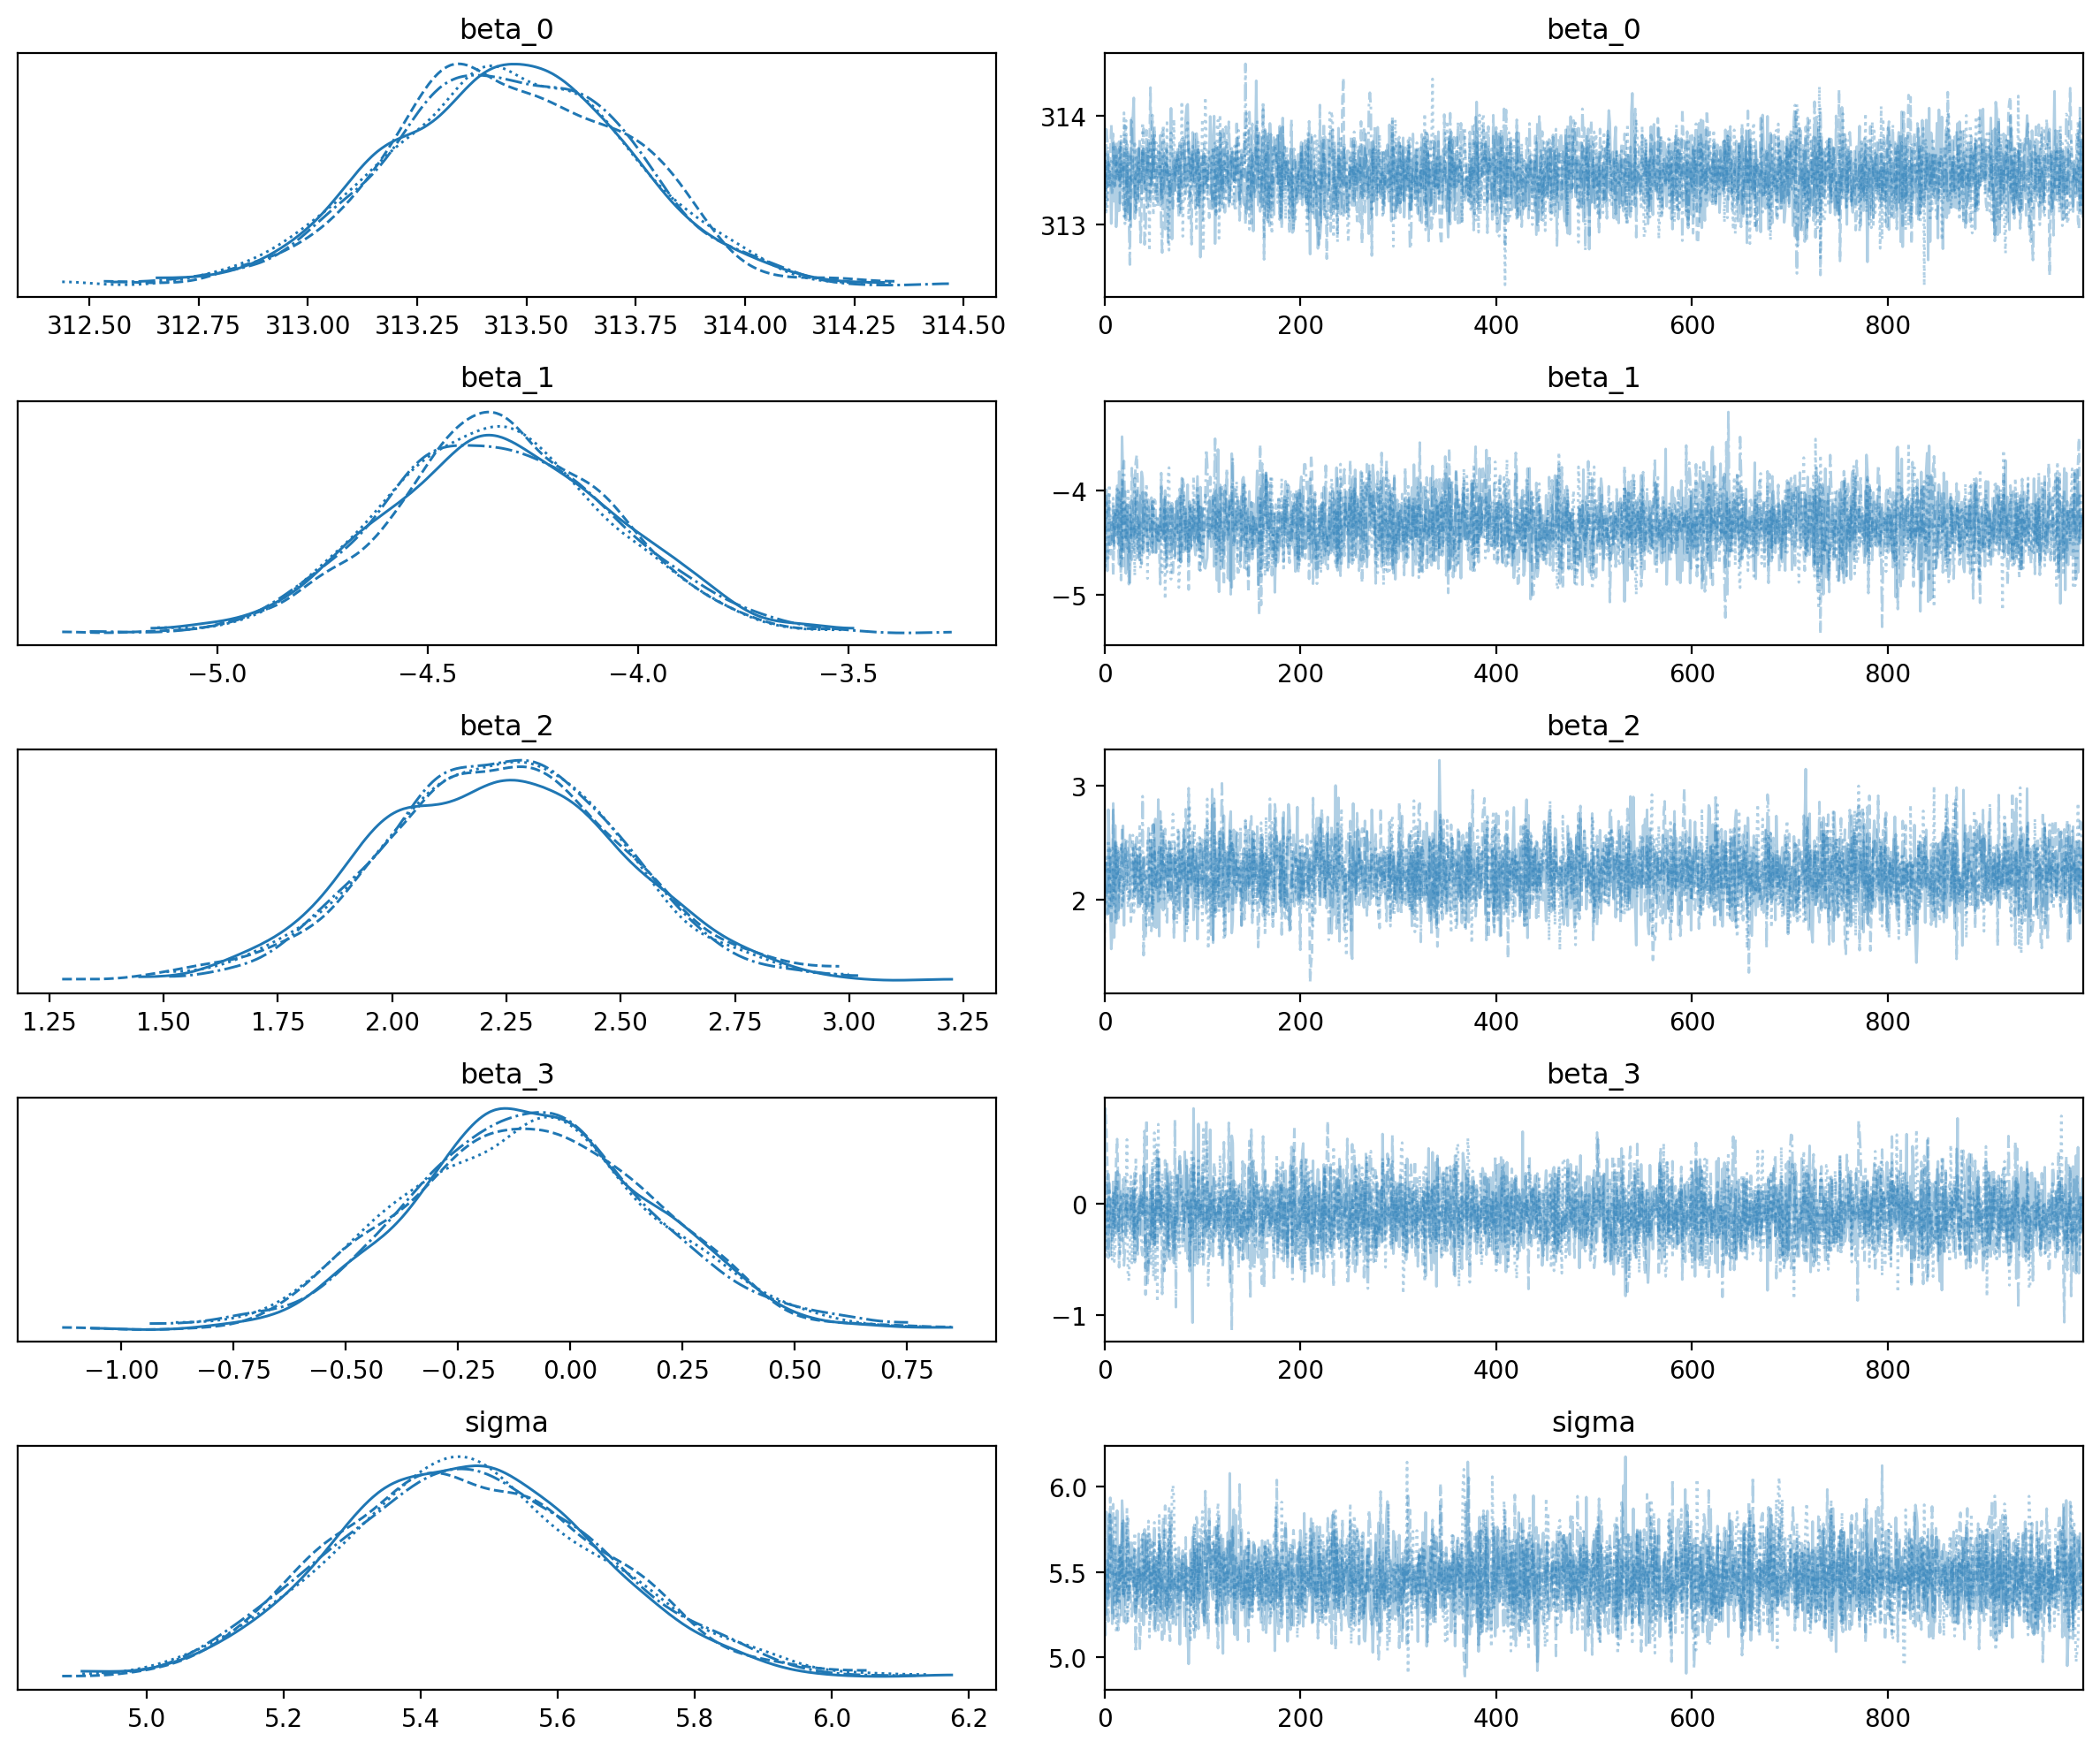

In [30]:
print(az.summary(trace_extended, var_names=['beta_0', 'beta_1', 'beta_2', 'beta_3', 'sigma'], hdi_prob=0.95))

# Trace plots
az.plot_trace(trace_extended, var_names=['beta_0', 'beta_1', 'beta_2', 'beta_3', 'sigma'])
plt.tight_layout()
plt.show()

The selection of prior distributions for the model, with house_taxes as a predictor, is grounded in reasonable assumptions about the relationships between the predictors and the utility bill, while accounting for uncertainty due to limited prior knowledge. For the intercept beta_0, a Normal(320, 50) prior is chosen, representing a reasonable central estimate for the utility bill, with some allowance for variability. The priors for the coefficients of avg_temperature beta_1, household_size beta_2, and house_taxes beta_3 are all set to Normal(0, 10), reflecting the expectation that these predictors may have small to moderate effects on the utility bill, but their precise influence is uncertain. These priors allow the model to adapt to the true relationships in the data without imposing overly strong assumptions. The error term sigma is modeled using a Normal(4, 1) prior on the log of the standard deviation, ensuring a positive error term and permitting moderate variability in the data. Overall, these priors offer a balanced approach, accommodating uncertainty, robustness to outliers, and flexibility in capturing real-world relationships between the predictors and the utility bill.

## G (10 points)

Interpret the mean of the posterior for the new parameter. Compare the other mean posterior values with those obtained in part E. Based on the scatter plot you obtained in part B, do you think this is a reasonable model? Comment on the relationship between the yearly property taxes and the utility bill amount. What do you think is happening here?

The mean of the posterior for the house_taxes parameter indicates whether property taxes are linked to utility bills. A positive value suggests that higher property taxes are correlated with higher utility bills, possibly due to factors like larger homes or more people consuming more utilities. By comparing this result to part E, where only avg_temperature and household_size were considered, we can analyse whether including house_taxes enhances the model's accuracy. According to the scatter plot from part B, if property taxes don’t show a strong connection with utility bills, their inclusion may not significantly impact the model. The relationship between property taxes and utility bills could be influenced by indirect factors like home size, but if the effect is weak, it would imply that property taxes do not have a substantial impact. Ultimately, the findings will reveal whether adding house_taxes improves the model or if temperature and household size alone suffice.